### Simulation

In [178]:
import scipy.linalg as la
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.decomposition import SparsePCA

In [81]:
def SSVD(x, gamma1 = 2, gamma2 = 2, tol = 1e-6, max_iter = 50):
    
    n, d = x.shape
    
    # Step1
    U, S, V = la.svd(x)
    Vt = V.T
    iters = 0
    converge_diff_u = tol + 1
    converge_diff_v = tol + 1
    
    U_old = U[:, 0]
    S_old = S[0]
    V_old = V[0, :]
    
    V_new = np.zeros(d)
    U_new = np.zeros(n)
    
    # Step 2
    while(converge_diff_u > tol and converge_diff_v > tol and iters < max_iter):
                
        iters += 1
        #update v
        V_hat = np.zeros(d)
        Xt_U = x.T @ U_old
        omega_2 = np.abs(Xt_U) ** (-gamma2)
        error_var = np.abs(np.sum(x ** 2) - sum(Xt_U**2))/(n*d-d)
        lambda_2 = np.unique(np.append(np.abs(Xt_U / omega_2), 0))
        lambda_2.sort()
        
        min_bic = np.Inf
        
        for l in lambda_2:
            
            ## Find all v's
            term1 = Xt_U / abs(Xt_U)
            term2 = abs(Xt_U) - l * omega_2 / 2
            term2 *= term2 >= 0
            V_hat = term1 * term2           
   
            ## Choose the best v based on bic
            bic = np.sum((x - U_old.reshape((-1, 1)) @
                          V_hat.reshape((1, -1)))**2) / error_var + np.sum(V_hat!=0) * np.log(n * d)
            if bic < min_bic:
                V_new = V_hat
                min_bic = bic
                
        s = np.linalg.norm(V_new)
        V_new = V_new / s
        
        #update U
        U_hat = np.zeros(n)
        X_V = x @ V_old
        
        omega_1 = np.abs(X_V) ** (-gamma1)
        error_var = np.abs(np.sum(x ** 2) - sum(X_V**2))/(n*d-n)
        lambda_1 = np.unique(np.append(np.abs(X_V / omega_1), 0))
        lambda_1.sort()
        
        min_bic = np.Inf
        
        for l in lambda_1:

            term1 = X_V / abs(X_V)
            term2 = abs(X_V) - l * omega_1 / 2
            term2 *= term2 >= 0
            U_hat = term1 * term2
            
            ## Choose the best v based on bic
            bic = np.sum((x - U_hat.reshape((-1, 1)) @
                          V_old.reshape((1, -1)))**2)/error_var + np.sum(U_hat!=0) * np.log(n * d)
            if bic < min_bic:
                U_new = U_hat
                min_bic = bic
                
        s = np.linalg.norm(U_new)
        U_new = U_new / s
                
        converge_diff_u = np.sqrt(np.sum((U_new - U_old) ** 2))
        converge_diff_v = np.sqrt(np.sum((V_new - V_old) ** 2))
        U_old = U_new
        V_old = V_new
                
    return U_new, S_old, V_new, iters

In [127]:
def SSVD_multi_layer(x, layers):
    
    n, d = x.shape
    all_layers_u = np.zeros((n, layers))
    all_layers_v = np.zeros((d, layers))
    all_layers_s = np.zeros(layers)
    
    for i in range(layers):
        u_new, s_new, v_new, iters = SSVD(x)
        layer = s_new * u_new.reshape((-1, 1)) @ v_new.reshape((1, -1))
        all_layers_u[:, i] = u_new
        all_layers_v[:, i] = v_new
        all_layers_s[i] = s_new
        x = x - layer
        
    return all_layers_u, all_layers_v

#### Rank 1 simulation

In order to closely examine the performance of our algorithm, we decided to carry out simulation studies. In this section, we will start by repeating a rank-1 simulation study suggested by Lee et al. (2010). In this designed simulation dataset, the target matrix $X$ has the dimension of $100 \times 50$. In a rank-1 approximation by our SSVD algorithm, the corresponding vectors $u$ and $v$ are designed to have 25 and 16 nonzero entries, respectively. The scaling eigenvalue associated with this case is set to be $50$. The final dataset also has error terms from a standard normal distribution added. And the entire data generating process is repeated 100 times. 

Ideally, we expect our algorithm to correctly detect the zero and nonzero entries from the original dataset. In this case, we collected the following statistics to evaluate its performance: number of zero entries, number of correctly specified zero entries and number of correctly specified nonzero entries. 

In [45]:
def rank1_approx(M = 100):
    """Carry out a rank-1 approximation simulation study"""
    
    u_tilde = np.concatenate((np.arange(3, 11)[::-1],
                          np.ones(17) * 2,
                          np.zeros(75)))
    u = u_tilde / np.linalg.norm(u_tilde)
    v_tilde = np.concatenate((np.array([10, -10, 8, -8, 5, -5]), 
                              np.ones(5) * 3,
                              np.ones(5) * (-3), 
                              np.zeros(34)))
    v = v_tilde / np.linalg.norm(v_tilde)
    s = 50
    x_sim_rank1 = s * u.reshape((-1, 1)) @ v.reshape((1, -1)) 
    
    v_nonzero_ind = np.where(v != 0)
    v_zero_ind = np.where(v == 0)
    u_nonzero_ind = np.where(u != 0)
    u_zero_ind = np.where(u == 0)
    
    v_zeros = np.zeros(M)
    v_true_zeros = np.zeros(M)
    v_true_nonzeros = np.zeros(M)
    
    u_zeros = np.zeros(M)
    u_true_zeros = np.zeros(M)
    u_true_nonzeros = np.zeros(M)
    
    
    for i in range(M):
        noise = np.random.normal(size = (x_sim_rank1.shape))
        u_appr, v_appr, iters = SSVD(x_sim_rank1 + noise)
        v_zeros[i] = np.sum(v_appr == 0)
        u_zeros[i] = np.sum(u_appr == 0)
        v_true_zeros[i] = np.sum(v_appr[v_zero_ind] == 0)
        u_true_zeros[i] = np.sum(u_appr[u_zero_ind] == 0)
        v_true_nonzeros[i] = np.sum(v_appr[v_nonzero_ind] != 0)
        u_true_nonzeros[i] = np.sum(u_appr[u_nonzero_ind] != 0)
        
    return np.array([v_zeros, v_true_zeros, v_true_nonzeros, u_zeros, u_true_zeros, u_true_nonzeros])


In [47]:
result = rank1_approx()
result = np.mean(result, axis = 1)

In [48]:
print("Average of correctly specified zero entries on u is", result[4] / result[3])
print("Average of correctly specified nonzero entries on u is", result[5] / 25)
print("Average of correctly specified zero entries on v is", result[1] / result[0])
print("Average of correctly specified nonzero entries on v is", result[2] / 16)

Average of correctly specified zero entries on u is 0.9974275656647712
Average of correctly specified nonzero entries on u is 0.9924
Average of correctly specified zero entries on v is 1.0
Average of correctly specified nonzero entries on v is 1.0


As we can read from our result, the simulation study on our rank-1 approximation is fairly accurate, with the biclustering identification rate close to 100% on both vector $u$ and $v$. Comparing with the table in Lee et al. (2010), we can observe that results are close. 

#### Rank-3 simulation

Continuing from the rank-1 approximation setup, we also want to generate a dataset with rank-3. In this simulation, we choose to use a dataset that is moderately sparse, and examine the performance of algorithm on each layer. 

In [147]:
A = np.random.poisson(1, (15,20)) * np.random.randint(0, 10, (15,20))
pd.DataFrame(A).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,8,0,4,2,5,0,15,16,8,0,0,0,12,0,16,0,0,3,1,5
1,0,0,0,4,14,10,1,5,7,0,0,0,0,0,3,0,0,0,5,0
2,16,24,0,0,1,2,0,2,4,0,0,0,0,0,0,4,0,5,9,2
3,0,12,0,27,8,0,0,8,4,0,2,8,14,8,21,16,0,0,3,4
4,0,0,16,2,18,1,2,10,10,1,0,16,6,6,0,5,0,0,7,0


In [148]:
SSVD_multi_layer(A, 3)

(array([[-0.26397692, -0.        , -0.        ],
        [-0.14262013, -0.        , -0.        ],
        [-0.16658881, -0.        , -0.64353233],
        [-0.38344559,  0.27739995, -0.        ],
        [-0.29644794,  0.        , -0.        ],
        [-0.26972807, -0.96075453, -0.        ],
        [-0.16868579, -0.        , -0.        ],
        [-0.27949814, -0.        , -0.        ],
        [-0.27532691, -0.        , -0.20297382],
        [-0.21895921, -0.        ,  0.        ],
        [-0.24744018,  0.        , -0.        ],
        [-0.26227689, -0.        ,  0.        ],
        [-0.16329265,  0.        , -0.        ],
        [-0.35217834, -0.        ,  0.6170232 ],
        [-0.25204502,  0.        , -0.40490757]]),
 array([[-0.12499331, -0.        , -0.18614254],
        [-0.29163015, -0.        , -0.76678149],
        [-0.27839955, -0.77836942,  0.        ],
        [-0.2364642 ,  0.19840004,  0.        ],
        [-0.39628209,  0.        , -0.        ],
        [-0.131782

As we can see from our result, when the target dataset is moderately sparse, the first layer of our SSVD algorithm does not perform biclustering. On the other hand, the second and the third layer have more zero entries and bicluster the dataset. 

### Application to real datasets

After some simulation studies on our algorithm, we want to apply it to real datasets to check its performance. Firstly, we choose the Lung Cancer dataset used in the paper Lee et al. (2010). The dataset contains 12625 rows and 56 columns, representing gene expressions and subjects, respectively. Notice from the heatmap below that the raw gene data appear to be unorganized. Our expected outcome of applying our SSVD algorithm to this dataset is to find clusters in the gene subjects. 

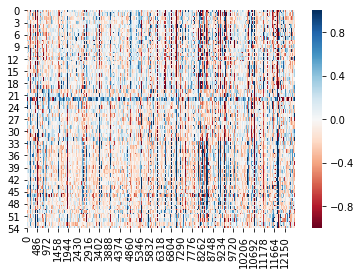

In [95]:
Lung_Cancer_data = np.loadtxt('./data/LungCancerData.txt')
X_Lung = Lung_Cancer_data.T

sns.heatmap(X_Lung, vmin=-1, vmax=1, cmap = 'RdBu')
pass

In [82]:
result_Lung = SSVD(X_Lung)
u, s, v, i = result_Lung

As suggested in Lee et al. (2010), we unselected 5000 genes in the white area. Then we rescaled the data to a $[-1, 1]$ interval for better visualization. 

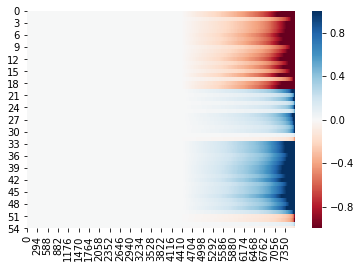

In [88]:
Lung_SSVD = s * u.reshape((-1, 1)) @ np.sort(np.abs(v))[5000:].reshape((1, -1))
sns.heatmap(Lung_SSVD, vmin=-1, vmax=1, cmap = 'RdBu')
pass

Note that the original gene data has four subjects. In other words, the genes are supposed to be grouped in 4 clusters. In our plot, we can observe that our gene data are grouped in 4 clusters at subjects #20, #30 and #51. Thus, the rank-1 SSVD by our algorithm is indeed useful in this dataset. We then proceed to the second layer of SSVD. 

In [89]:
result_Lung2 = SSVD(X_Lung - s * u.reshape((-1, 1)) @ v.reshape((1, -1)))
u2, s2, v2, i2 = result_Lung2

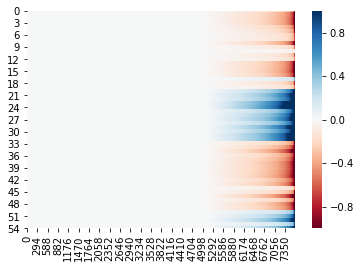

In [91]:
Lung_SSVD2 = s2 * u2.reshape((-1, 1)) @ np.sort(np.abs(v2))[5000:].reshape((1, -1))
sns.heatmap(Lung_SSVD2, vmin=-1, vmax=1, cmap = 'RdBu')
pass

In the heatmap of the second layer, we can notice that the number of genes used to cluster data is less than of from the first layer. Also, we can notice that the difference between the seond and the third cluster, though not very clear in the first layer, is obvious in this layer as they are different in signs. 

In [93]:
result_Lung3 = SSVD(X_Lung - s * u.reshape((-1, 1)) @ v.reshape((1, -1)) -
                     s2 * u2.reshape((-1, 1)) @ v2.reshape((1, -1)))
u3, s3, v3, i3 = result_Lung3

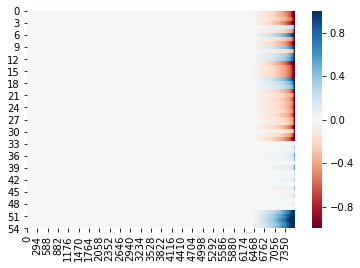

In [94]:
Lung_SSVD3 = s3 * u3.reshape((-1, 1)) @ np.sort(np.abs(v3))[5000:].reshape((1, -1))
sns.heatmap(Lung_SSVD3, vmin=-1, vmax=1, cmap = 'RdBu')
pass

At layer 3, we can notice that the number of genes used to cluster data is significantly less than that of the first two layers. We can also observe that in this layer, only the last group are being clearly clustered by our algorithm, while the first two groups are blur in our graph. 

Another dataset from other sources we want to use is used in a proof-of-concept study published in 1999 by Golub et al. Essentially, there are two underlying clusters in the gene data. Similarly, we want our SSVD algorithm to locate these two clusters. Below are a snapshot of our data, and a heatmap of the raw data before clustering. 

In [102]:
gene_expr = pd.read_csv('./data/GolubGeneExpression.csv', sep=',', index_col=0, header=0)
gene_expr.head()

,0,1,2,3,4,5,6,7,8,9,...,7119,7120,7121,7122,7123,7124,7125,7126,7127,7128
0,-0.229573,-0.227176,-0.223444,-0.217709,-0.232755,-0.243086,-0.213349,-0.228080,-0.211266,-0.213074,...,-0.213898,-0.201092,-0.226076,-0.205885,-0.222619,-0.190014,-0.208242,-0.219752,-0.213663,-0.222619
1,-0.246431,-0.243636,-0.240586,-0.228557,-0.251726,-0.257487,-0.254522,-0.247660,-0.236266,-0.237409,...,-0.233386,-0.205091,-0.242069,-0.221822,-0.241264,-0.207421,-0.228049,-0.240078,-0.237325,-0.241137
2,-0.018574,-0.017597,-0.026938,-0.004634,-0.029436,-0.039357,-0.014628,-0.029110,-0.008364,-0.023607,...,-0.004417,0.027590,-0.014628,-0.009740,-0.013940,0.025381,0.012310,-0.014338,-0.007567,-0.017307
3,-0.151755,-0.150989,-0.137168,-0.146394,-0.162111,-0.168165,-0.141070,-0.156058,-0.145045,-0.145702,...,-0.138080,-0.116383,-0.138882,-0.140487,-0.150843,-0.123968,-0.140633,-0.148655,-0.142237,-0.150150
4,-0.486836,-0.487789,-0.485332,-0.473096,-0.493055,-0.495762,-0.481320,-0.487639,-0.478010,-0.468883,...,-0.473697,-0.448974,-0.478662,-0.456246,-0.482824,-0.468984,-0.465774,-0.480818,-0.478712,-0.482774


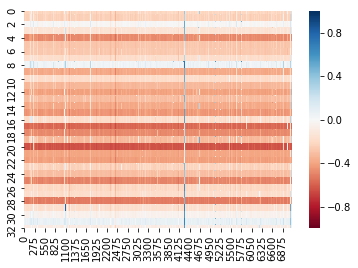

In [103]:
x_gene = np.array(gene_expr)
sns.heatmap(x_gene, vmin=-1, vmax=1, cmap = 'RdBu')
pass

In [105]:
result_Gene = SSVD(x_gene)
u, s, v, i = result_Gene

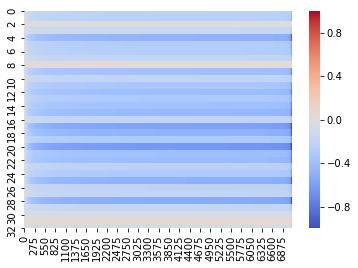

In [115]:
Gene_SSVD = s * u.reshape((-1, 1)) @ np.sort(np.abs(v)).reshape((1, -1))
sns.heatmap(Gene_SSVD, vmin=-1, vmax=1, cmap = 'coolwarm')
pass

In the originial dataset, the first 27 genes and the last 8 genes belong to two different groups. In our heatmap, we can roughly see a clustering effect around gene #28, where the color underneath that has a warmer color. However, we should also notive that the warm color appears at other genes, indicating that the algorithm fails to correctly indentify those genes. 

### Comparative analysis with competing algorithms

In the comparative analysis, we want to compare the bicluster performance in terms of accuracy between our SSVD algorithm and some similar models: the standard SVD method and the Sparse Principle Component Analysis (SPCA). The statistics we choose in the analysis are suggested by Lee et al. and are the same in the simulation section: number of zero entries, number of correctly specified zero entries, number of correctly specified nonzero entries and the misclasscification rate. 

In [ ]:
u_tilde = np.concatenate((np.arange(3, 11)[::-1],
                      np.ones(17) * 2,
                      np.zeros(75)))
u = u_tilde / np.linalg.norm(u_tilde)
v_tilde = np.concatenate((np.array([10, -10, 8, -8, 5, -5]), 
                          np.ones(5) * 3,
                          np.ones(5) * (-3), 
                          np.zeros(34)))
v = v_tilde / np.linalg.norm(v_tilde)
s = 50
x_sim = s * u.reshape((-1, 1)) @ v.reshape((1, -1)) 


In [225]:
def num_zeros(approx): 
    
    return np.sum(approx == 0)

def num_crct_zeros(approx, orig):
    
    ind = np.where(approx == 0)
    return np.sum(orig[ind] == 0)

def num_crct_nzeros(approx, orig):
    
    ind = np.where(approx != 0)    
    return np.sum(orig[ind] != 0)

In [254]:
def all_approx(M = 100):
    
    
    u_tilde = np.concatenate((np.arange(3, 11)[::-1],
                      np.ones(17) * 2,
                      np.zeros(75)))
    u = u_tilde / np.linalg.norm(u_tilde)
    v_tilde = np.concatenate((np.array([10, -10, 8, -8, 5, -5]), 
                              np.ones(5) * 3,
                              np.ones(5) * (-3), 
                              np.zeros(34)))
    v = v_tilde / np.linalg.norm(v_tilde)
    s = 50
    x_sim = s * u.reshape((-1, 1)) @ v.reshape((1, -1)) 
    
    zeros = np.zeros((M, 6))
    crct_zeros = np.zeros((M, 6))
    crct_nzeros = np.zeros((M, 6))
    n_all = np.concatenate((np.ones(3) * 100, np.ones(3) * 50))
    
    for i in range(M):
        noise = np.random.normal(size = x_sim.shape)
        ssvd_u, ssvd_s, ssvd_v, ssvd_i = SSVD(x_sim + noise)
        svd_u, svd_s, svd_v = la.svd(x_sim + noise)
        svd_u = svd_u[:, 0]
        svd_v = svd_v[0, :]
        spca_model = SparsePCA(n_components=1)
        spca_model.fit(x_sim + noise)
        spca_v = spca_model.components_[0]
        spca_model.fit((x_sim + noise).T)
        spca_u = spca_model.components_[0]
        
        list_of_approx_u = [ssvd_u, svd_u, spca_u]
        list_of_approx_v = [ssvd_v, svd_v, spca_v]
        
        zeros[i, :] = np.array(list(map(num_zeros, list_of_approx_u + list_of_approx_v)))
        crct_zeros[i, :] = np.array(list(map(num_crct_zeros, list_of_approx_u, [u] * 3)) + 
                                       list(map(num_crct_zeros, list_of_approx_v, [v] * 3)))
        crct_nzeros[i, :] = np.array(list(map(num_crct_nzeros, list_of_approx_u, [u] * 3)) + 
                                       list(map(num_crct_nzeros, list_of_approx_v, [v] * 3)))
 

    return np.array([np.mean(zeros, axis = 0), 
                   np.mean(crct_zeros, axis = 0), 
                   np.mean(crct_zeros, axis = 0) / np.mean(zeros, axis = 0), 
                   np.mean(crct_nzeros, axis = 0), 
                   np.mean(crct_nzeros, axis = 0) / (n_all - np.mean(zeros, axis = 0)), 
                   ((np.mean(zeros, axis = 0) - np.mean(crct_zeros, axis = 0)) +
                    (n_all - np.mean(zeros, axis = 0) - np.mean(crct_nzeros, axis = 0))) / n_all
                    ])


In [255]:
result = all_approx()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


array([[7.37300000e+01, 0.00000000e+00, 5.20800000e+01, 3.20100000e+01,
        0.00000000e+00, 2.30200000e+01],
       [7.35700000e+01, 0.00000000e+00, 5.20700000e+01, 3.20100000e+01,
        0.00000000e+00, 2.30200000e+01],
       [9.97829920e-01,            nan, 9.99807988e-01, 1.00000000e+00,
                   nan, 1.00000000e+00],
       [2.48400000e+01, 2.50000000e+01, 2.49900000e+01, 1.60000000e+01,
        1.60000000e+01, 1.60000000e+01],
       [9.45565284e-01, 2.50000000e-01, 5.21494157e-01, 8.89382991e-01,
        3.20000000e-01, 5.93031875e-01],
       [1.59000000e-02, 7.50000000e-01, 2.29400000e-01, 3.98000000e-02,
        6.80000000e-01, 2.19600000e-01]])

In [ ]:
result

 #### below are trash

In [238]:

u_tilde = np.concatenate((np.arange(3, 11)[::-1],
                  np.ones(17) * 2,
                  np.zeros(75)))
u = u_tilde / np.linalg.norm(u_tilde)
v_tilde = np.concatenate((np.array([10, -10, 8, -8, 5, -5]), 
                          np.ones(5) * 3,
                          np.ones(5) * (-3), 
                          np.zeros(34)))
v = v_tilde / np.linalg.norm(v_tilde)
s = 50
x_sim = s * u.reshape((-1, 1)) @ v.reshape((1, -1)) 

zeros = np.zeros((M, 6))
crct_zeros = np.zeros((M, 6))
crct_nzeros = np.zeros((M, 6))
n_all = np.concatenate((np.ones(3) * 100, np.ones(3) * 50))

for i in range(M):
    noise = np.random.normal(size = x_sim.shape)
    ssvd_u, ssvd_s, ssvd_v, ssvd_i = SSVD(x_sim + noise)
    svd_u, svd_s, svd_v = la.svd(x_sim + noise)
    svd_u = svd_u[:, 0]
    svd_v = svd_v[0, :]
    spca_model = SparsePCA(n_components=1)
    spca_model.fit(x_sim + noise)
    spca_v = spca_model.components_[0]
    spca_model.fit((x_sim + noise).T)
    spca_u = spca_model.components_[0]

    list_of_approx_u = [ssvd_u, svd_u, spca_u]
    list_of_approx_v = [ssvd_v, svd_v, spca_v]

    zeros[i, :] = np.array(list(map(num_zeros, list_of_approx_u + list_of_approx_v)))
    crct_zeros[i, :] = np.array(list(map(num_crct_zeros, list_of_approx_u, [u] * 3)) + 
                                   list(map(num_crct_zeros, list_of_approx_v, [v] * 3)))
    crct_nzeros[i, :] = np.array(list(map(num_crct_nzeros, list_of_approx_u, [u] * 3)) + 
                                   list(map(num_crct_nzeros, list_of_approx_v, [v] * 3)))


In [253]:
np.array([np.mean(zeros, axis = 0), 
       np.mean(crct_zeros, axis = 0), 
       np.mean(crct_zeros, axis = 0) / np.mean(zeros, axis = 0), 
       np.mean(crct_nzeros, axis = 0), 
       np.mean(crct_nzeros, axis = 0) / (n_all - np.mean(zeros, axis = 0)), 
       ((np.mean(zeros, axis = 0) - np.mean(crct_zeros, axis = 0)) + (n_all - np.mean(zeros, axis = 0) - np.mean(crct_nzeros, axis = 0))) / n_all
         ])


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


array([[7.35300000e+01, 0.00000000e+00, 5.15500000e+01, 3.21200000e+01,
        0.00000000e+00, 2.32000000e+01],
       [7.33000000e+01, 0.00000000e+00, 5.15500000e+01, 3.21200000e+01,
        0.00000000e+00, 2.32000000e+01],
       [9.96872025e-01,            nan, 1.00000000e+00, 1.00000000e+00,
                   nan, 1.00000000e+00],
       [2.47700000e+01, 2.50000000e+01, 2.50000000e+01, 1.60000000e+01,
        1.60000000e+01, 1.60000000e+01],
       [9.35776351e-01, 2.50000000e-01, 5.15995872e-01, 8.94854586e-01,
        3.20000000e-01, 5.97014925e-01],
       [1.93000000e-02, 7.50000000e-01, 2.34500000e-01, 3.76000000e-02,
        6.80000000e-01, 2.16000000e-01]])

In [250]:
((np.mean(zeros, axis = 0) - np.mean(crct_zeros, axis = 0)) +
(n_all - np.mean(zeros, axis = 0) - np.mean(crct_nzeros, axis = 0))) / n_all

array([0.0193, 0.75  , 0.2345, 0.0376, 0.68  , 0.216 ])

In [215]:
num_crct_zeros(list_of_approx_u[0], u)

TypeError: 'numpy.ndarray' object is not callable

In [228]:
num_crct_zeros(np.array([1,2,3,0]), np.array([1,0,3,0]))

1